# Distribution Approach
Interferometry tracks the ToF, giving us an intensity distribution over time. Assuming the refractive indices are similar across the entire tissue structure/body, photon total path ($\sum_{i=1}^{T}L_i$; with T being the number of tissue layers) can be a proxy for time. (If the refractive indices are different, we need to calculate the speed of light in each tissue layer/medium separately and then calculate the actual ToF for each photon. Although that approach is tractable in our setup, it's simpler to assume the speed of light remains constant for now.) So, the simulation plots we are interested in are Intensity($<G, A>$) vs. Photon total path($\sum_{i=1}^{T}L_i$)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from ipywidgets import interact
import ipywidgets as widgets
from tfo_sensitivity.data import load_raw


# Pre-calculated intensity using the regular formula (inner product)
# INTENSITY_DATA_PATH = Path('../data/s_based_intensity_low_conc2.pkl')

# intensity_data = pd.read_pickle(INTENSITY_DATA_PATH)
# intensity_data = intensity_data[(intensity_data['Maternal Wall Thickness'] == maternal_wall_thickness) & (intensity_data['Wave Int'] == wave_int)]

maternal_wall_thickness, uterus_thickness, wave_int = 4, 5, 1
raw_sim_data_path = load_raw(
    maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100

In [2]:
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from tfo_sensitivity.fmcw import create_quantized_tof


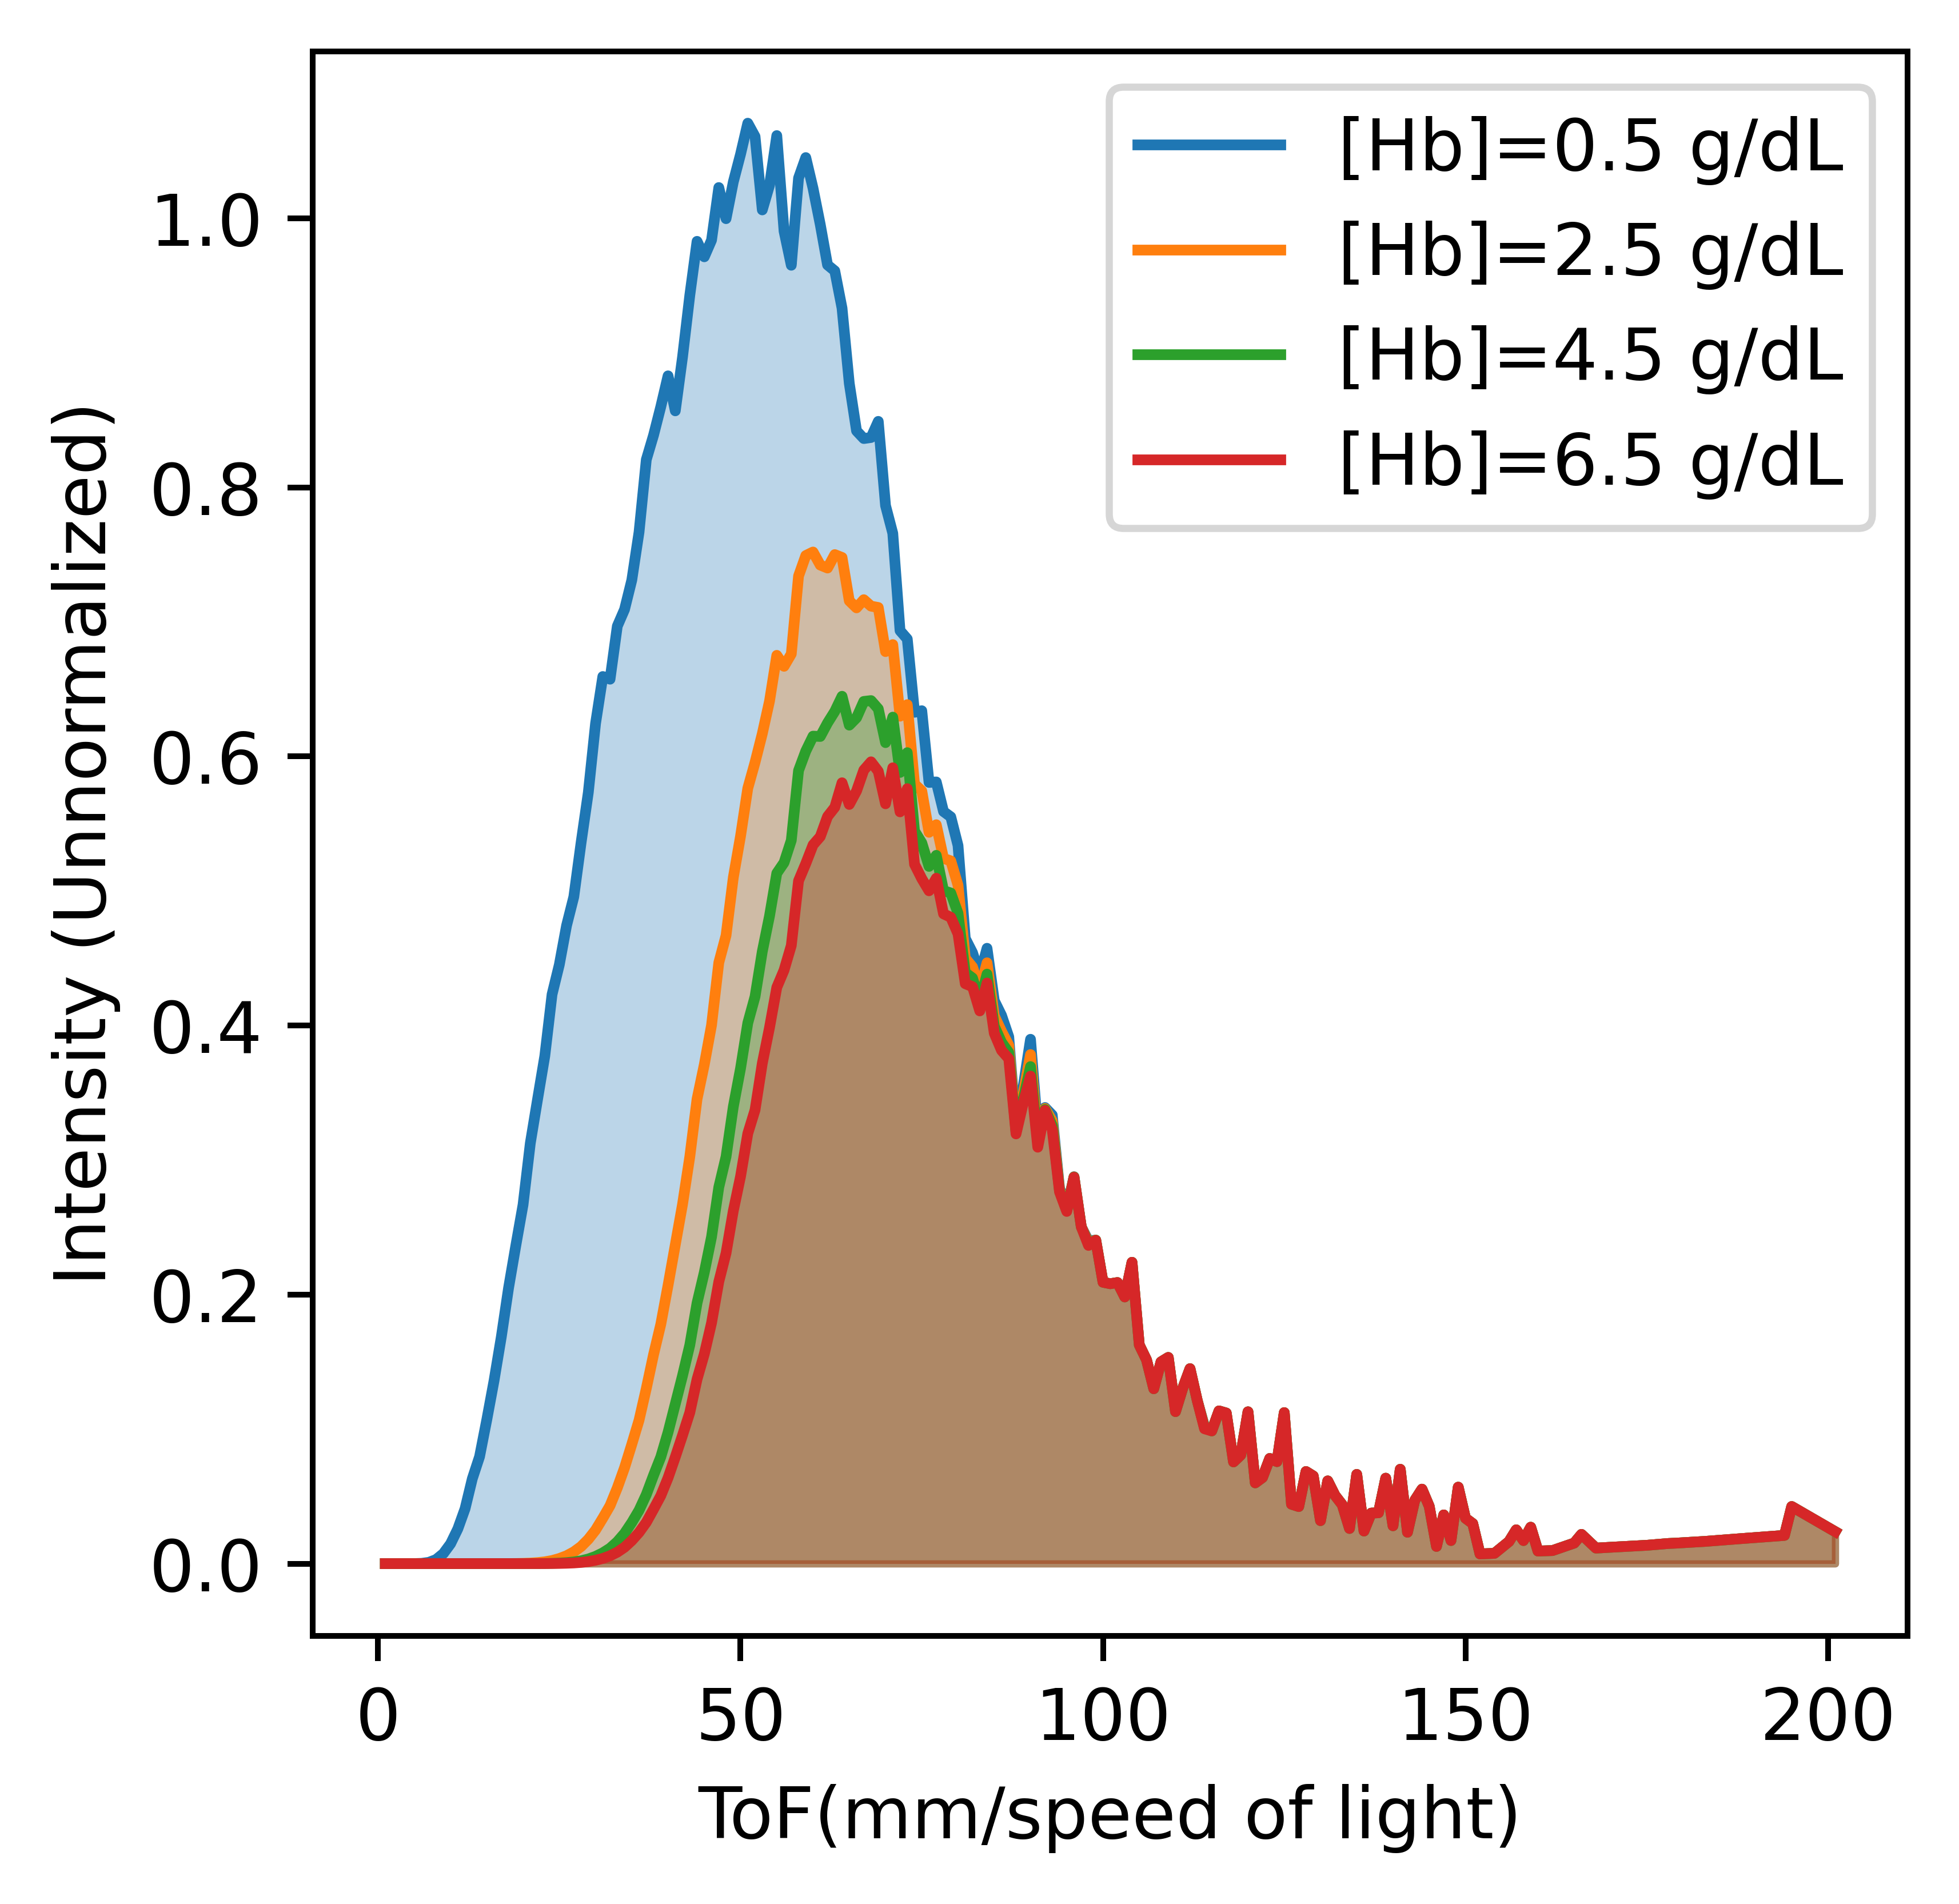

In [3]:
DIGITIZATION_BIN_COUNT = 200

SDD_INDEX = 3

MATERNAL_Hb = 5.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225

all_mean = []
all_skew = []
all_std = []
all_c = np.arange(0.5, stop=8.2, step=2.0)
modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
epsilon = get_mu_a(FETAL_SAT, 1, wave_int) 
all_sdd = raw_sim_data['SDD'].unique()

plt.figure(figsize=(4, 4), dpi=900)
for c in all_c:
    SDD = all_sdd[SDD_INDEX]
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD].copy()
    create_quantized_tof(filtered_photon_data, DIGITIZATION_BIN_COUNT)
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L = filtered_photon_data['L4 ppath'].to_numpy()
    transformed_L = np.exp(- epsilon * c * L)
    I = G * transformed_L
    filtered_photon_data["Intensity"] = I
    intensity_v_L = filtered_photon_data.groupby("ToF")["Intensity"].sum()
    line, = plt.plot(intensity_v_L, label=f'[Hb]={c} g/dL')
    plt.fill_between(intensity_v_L.index, intensity_v_L, color=line.get_color(), alpha=0.3)

plt.legend()
plt.xlabel('ToF(mm/speed of light)')
plt.ylabel('Intensity (Unnormalized)')
    

plt.show()


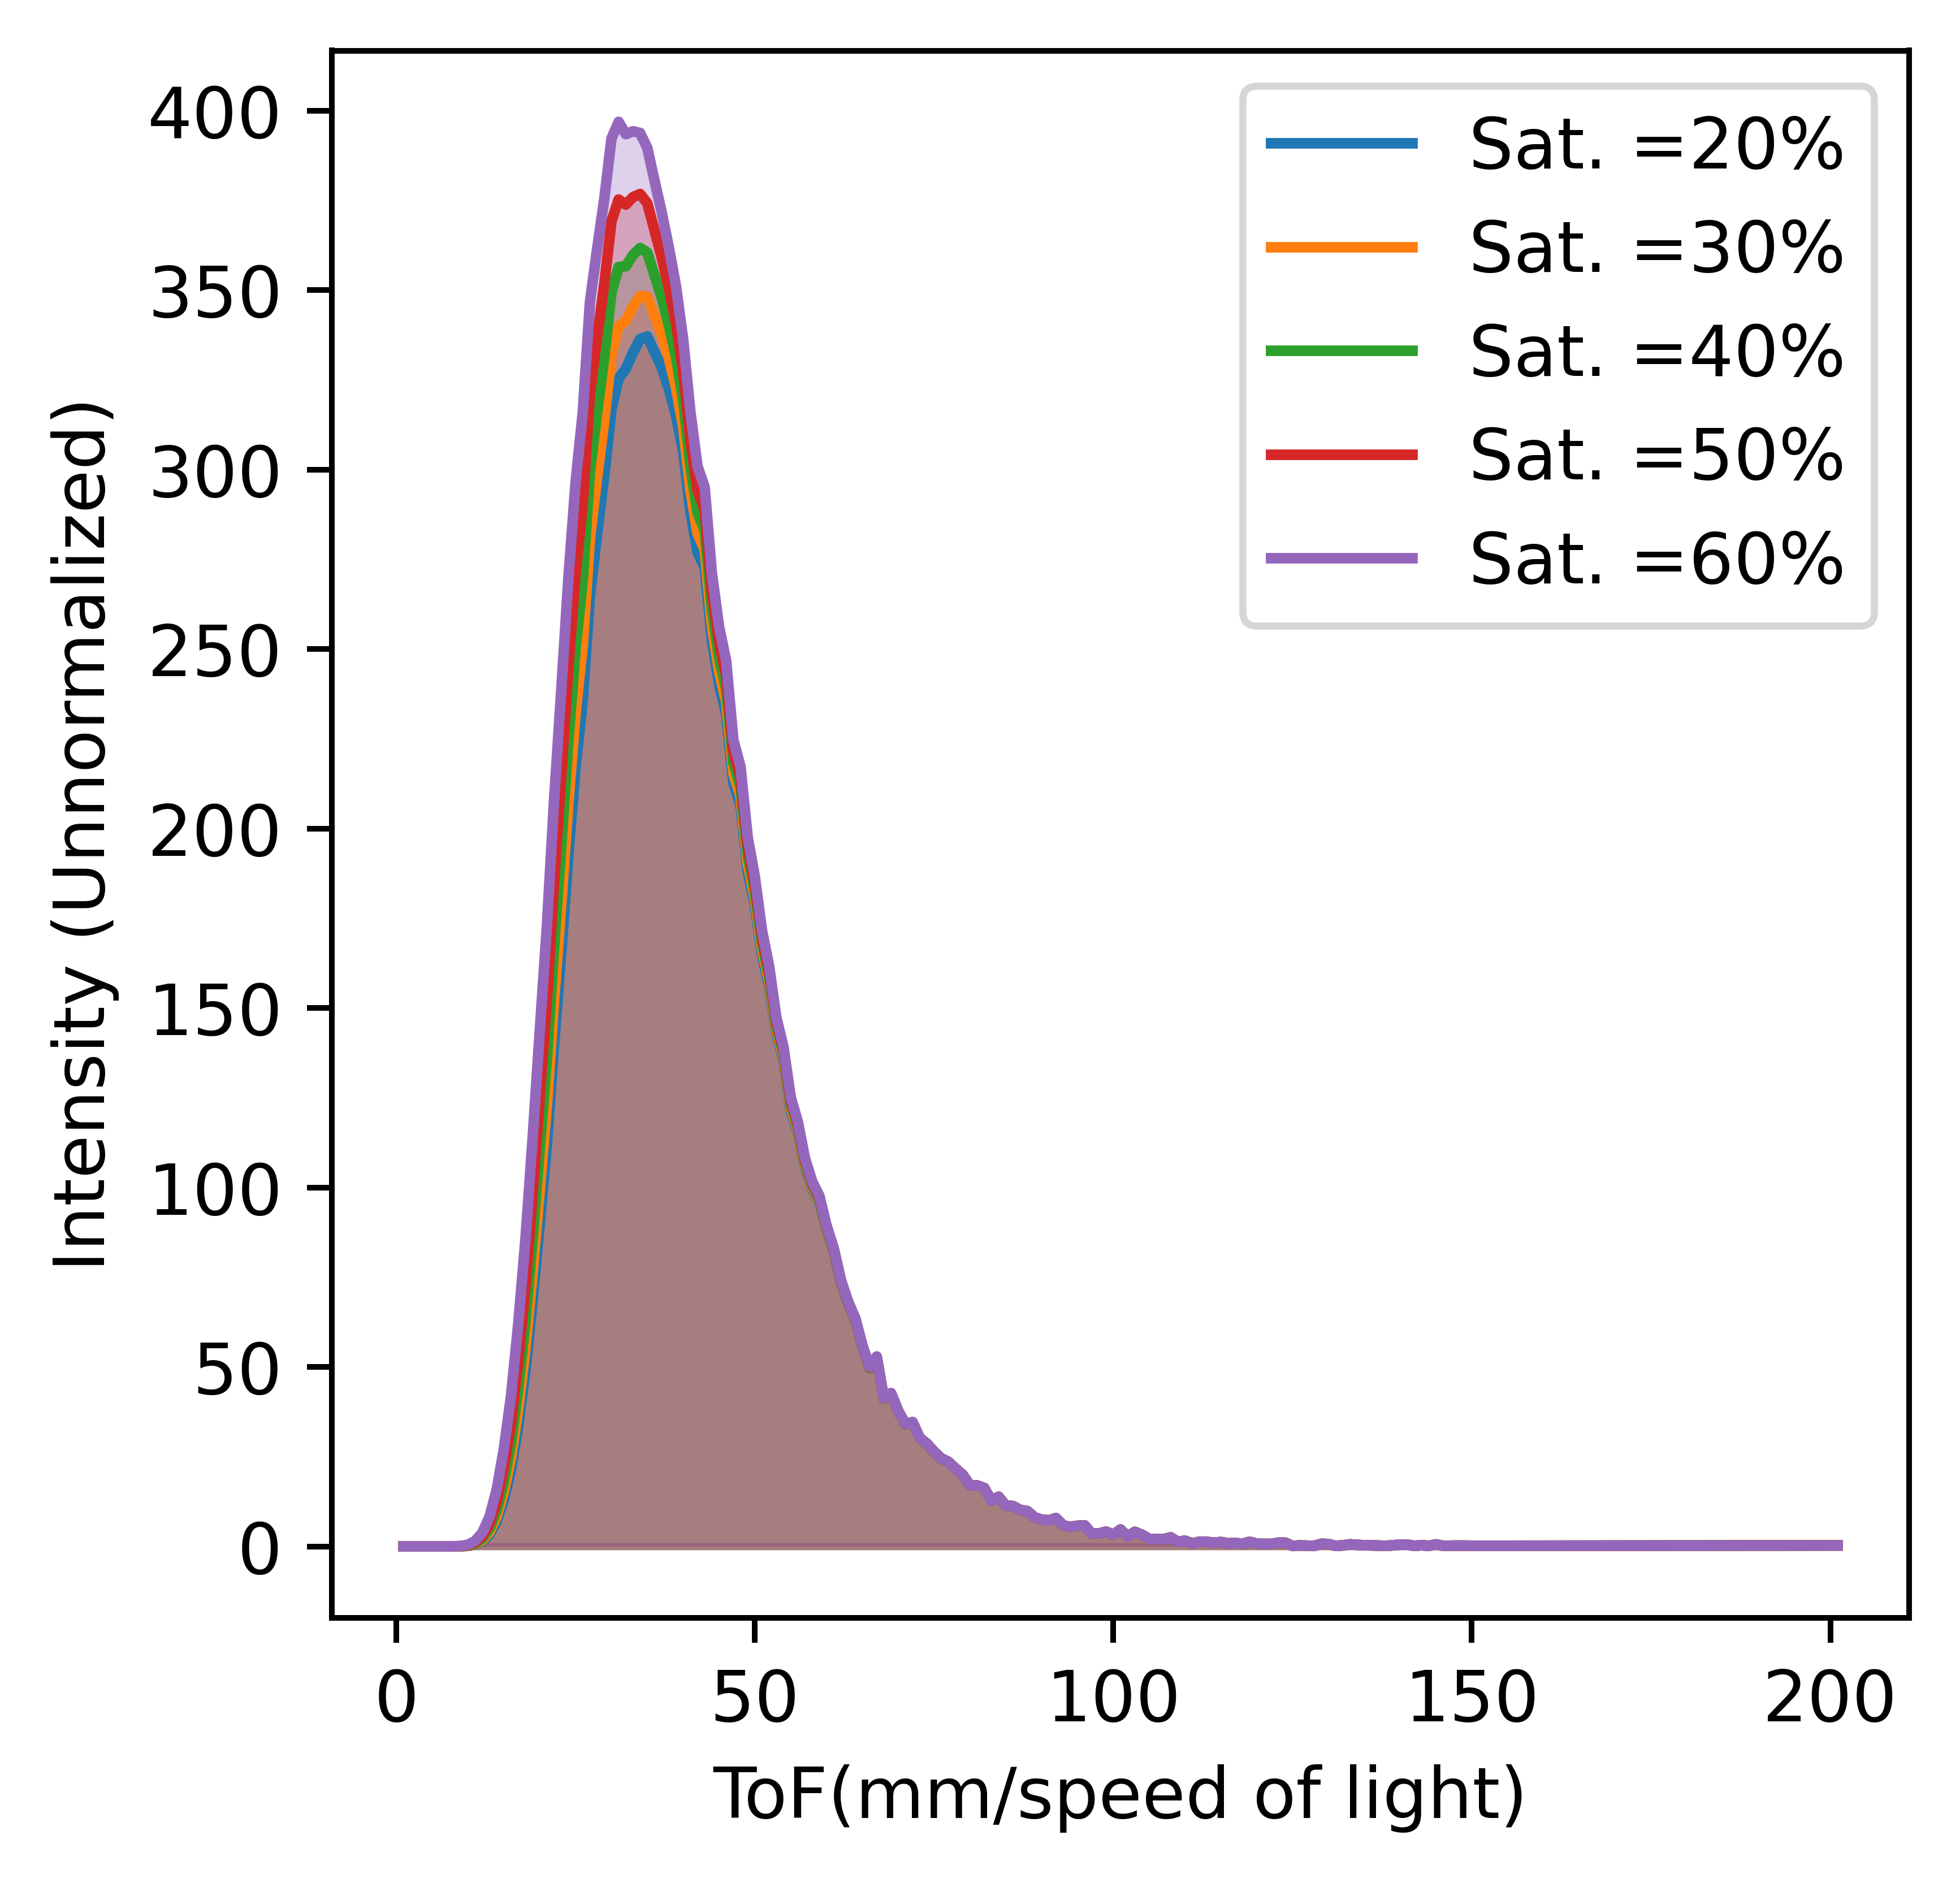

In [16]:
DIGITIZATION_BIN_COUNT = 200

SDD_INDEX = 3

MATERNAL_Hb = 5.
MATERNAL_SAT = 1.0
FETAL_Hb = 2.0

all_mean = []
all_skew = []
all_std = []
all_sat = np.arange(0.2, stop=0.7, step=0.1)
modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
all_sdd = raw_sim_data['SDD'].unique()

plt.figure(figsize=(4, 4), dpi=900)
for sat in all_sat:
    SDD = all_sdd[SDD_INDEX]
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD].copy()
    create_quantized_tof(filtered_photon_data, DIGITIZATION_BIN_COUNT)
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L = filtered_photon_data['L4 ppath'].to_numpy()
    mu_a = get_mu_a(sat, FETAL_Hb, wave_int)
    transformed_L = np.exp(- mu_a * L)
    I = G * transformed_L
    filtered_photon_data["Intensity"] = I
    intensity_v_L = filtered_photon_data.groupby("ToF")["Intensity"].sum()
    line, = plt.plot(intensity_v_L, label=f'Sat. ={sat * 100:2.0f}%')
    plt.fill_between(intensity_v_L.index, intensity_v_L, color=line.get_color(), alpha=0.3)

plt.legend()
plt.xlabel('ToF(mm/speed of light)')
plt.ylabel('Intensity (Unnormalized)')
    

plt.show()

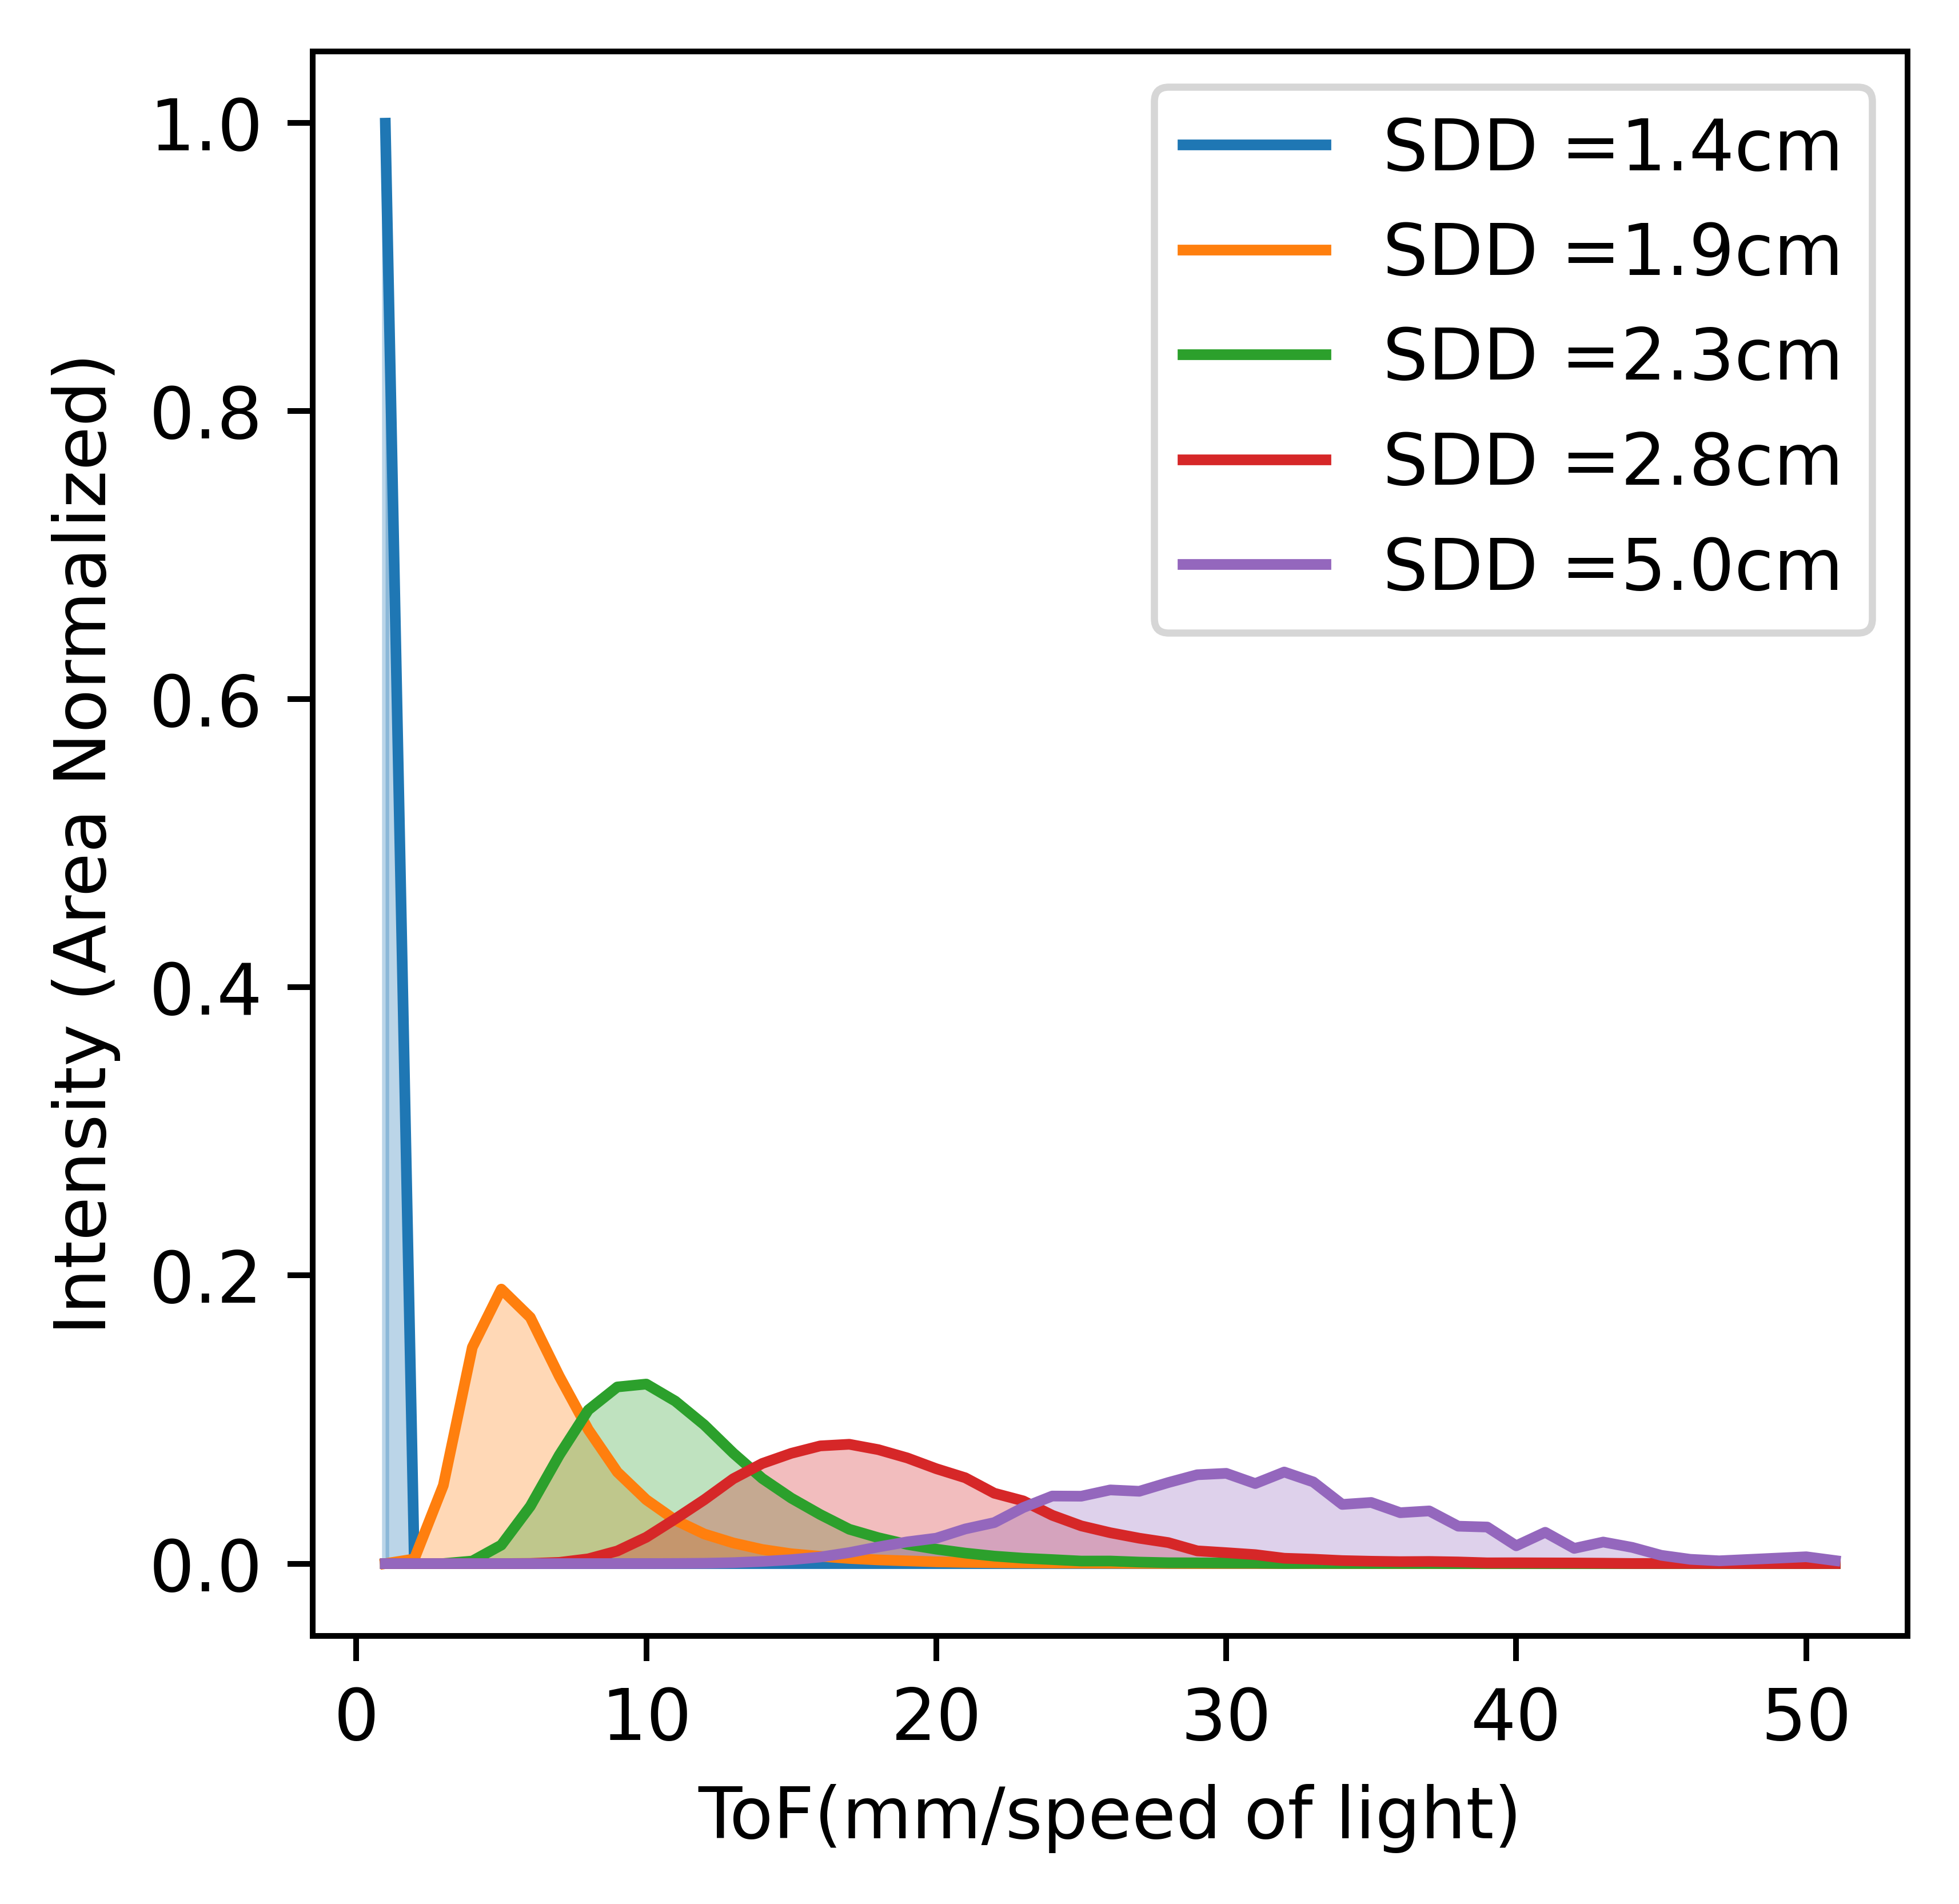

In [15]:
from tfo_sensitivity.fmcw import create_quantized_tof


MATERNAL_Hb = 5.
MATERNAL_SAT = 1.0
FETAL_Hb = 5.0
FETAL_SAT = 0.4

all_mean = []
all_skew = []
all_std = []
all_dets = np.arange(1, 6, step=1)
modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
all_sdd = raw_sim_data['SDD'].unique()

plt.figure(figsize=(4, 4), dpi=900)
for det_index in all_dets:
    SDD = all_sdd[det_index]
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD].copy()
    create_quantized_tof(filtered_photon_data, 50)
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L = filtered_photon_data['L4 ppath'].to_numpy()
    mu_a = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int)
    transformed_L = np.exp(- mu_a * L)
    I = G * transformed_L
    filtered_photon_data["Intensity"] = I
    intensity_v_L = filtered_photon_data.groupby("ToF")["Intensity"].sum()
    intensity_v_L /= intensity_v_L.sum()
    line, = plt.plot(intensity_v_L, label=f'SDD ={SDD/10:2.1f}cm')
    plt.fill_between(intensity_v_L.index, intensity_v_L, color=line.get_color(), alpha=0.3)

plt.legend()
plt.xlabel('ToF(mm/speed of light)')
plt.ylabel('Intensity (Area Normalized)')
    

plt.show()